# Modeling complex time series

In [34]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Forecasting bandwidth usage for data centers

In [35]:
df = pd.read_csv('data/bandwidth.csv')
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


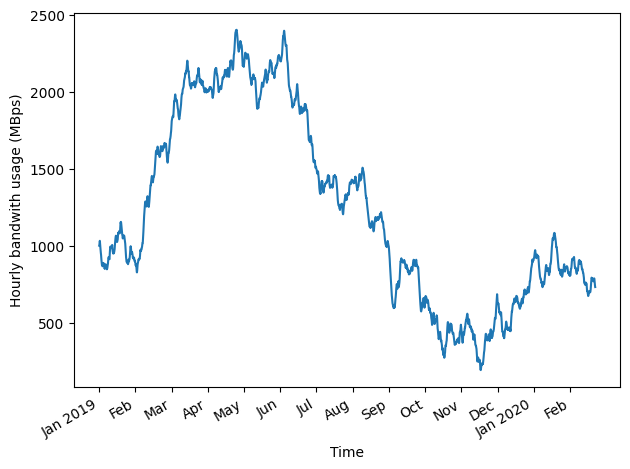

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

## Examining the autoregressive moving average process

**The autoregressive moving average process is a combination of the autoregressive process
and the moving average process.**

## Identifying a stationary ARMA process

**If neither of the ACF and PACF plots shows a clear cutoff
between significant and non-significant coefficients, then we have an ARMA(p,q)
process.**

<img src="images/tsf_05.png">

In [37]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [38]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042683
p-value: 1.7078466680097572e-08


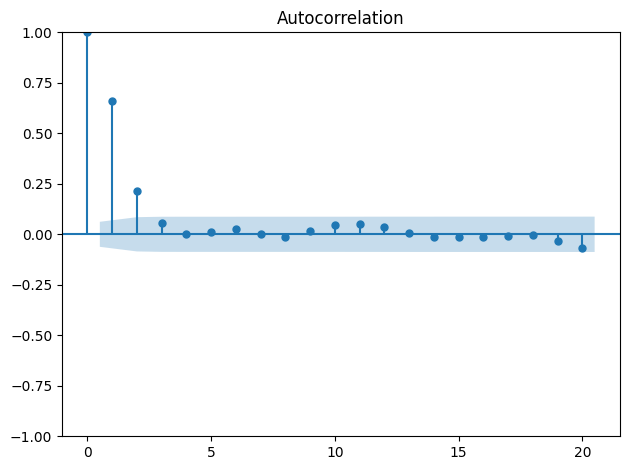

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ARMA_1_1, lags=20);
plt.tight_layout()

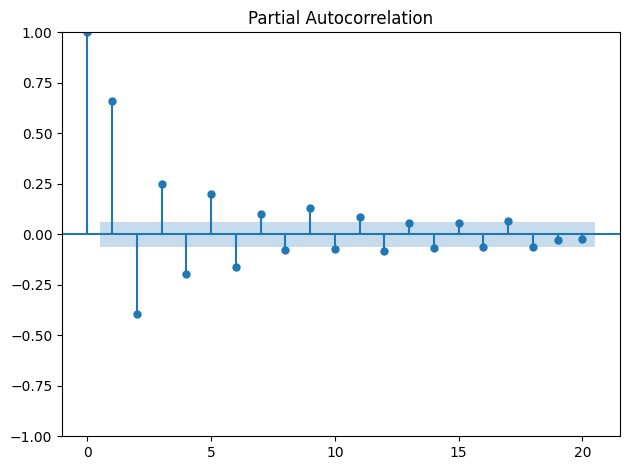

In [40]:
plot_pacf(ARMA_1_1, lags=20, method='ywm');
plt.tight_layout()

> If your process is stationary and both the ACF and PACF plots show a decaying or sinusoidal
pattern, then it is a stationary ARMA(p,q) process.

## Devising a general modeling procedure

<img src="images/tsf_06.png">

General modeling procedure for an ARMA(p,q) process: 
1. The first steps are to gather the data, test for stationarity, and apply transformations accordingly. 
2. Then we define a list of possible values for p and q. 
3. We then fit every combination of ARMA(p,q) to our data and select the model with the lowest AIC. 
4. Then we perform the residual analysis by looking at the Q-Q plot and the residual correlogram. 
5. If they approach that of white noise, the model can be used for forecasts. Otherwise, we must try different values for p and q.

## Understanding the Akaike information criterion (AIC)

**The AIC estimates the quality of a model relative to other models.** 

**The lower the value of the AIC, the better the model.** 

In [41]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [42]:
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [43]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.167826
8,"(2, 3)",2806.175378
9,"(3, 2)",2806.894930


## Understanding residual analysis

We **must measure its
absolute quality by performing an analysis on the model’s residuals.**

Does:
1. the Q-Q plot show a straight line, and
2. are the residuals uncorrelated? 

If the answer to both questions is yes, then we have a
model that’s ready to make forecasts. Otherwise, we must try different combinations
of (p,q) and restart the process.

**A Q-Q plot is a plot of the quantiles of two distributions against each other. In time
series forecasting, we plot the distribution of our residuals on the y-axis against the
theoretical normal distribution on the x-axis.**

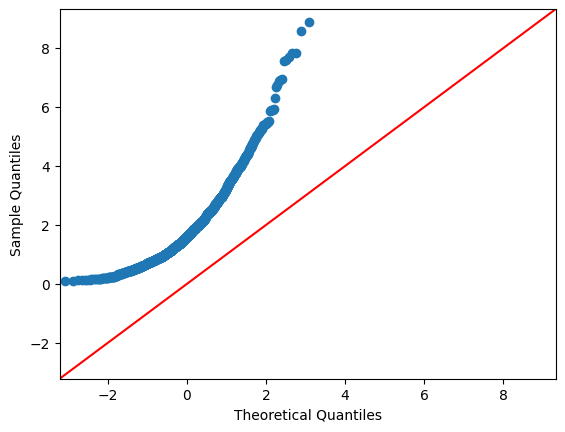

In [44]:
from statsmodels.graphics.gofplots import qqplot
gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)
qqplot(gamma, line='45');

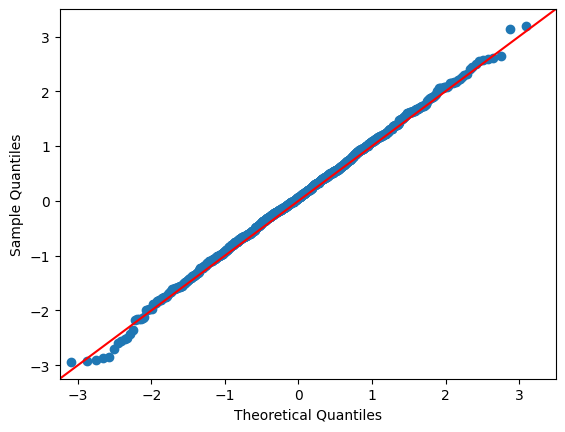

In [45]:
normal = np.random.normal(size=1000)
qqplot(normal, line='45');

## Performing residual analysis

In [46]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

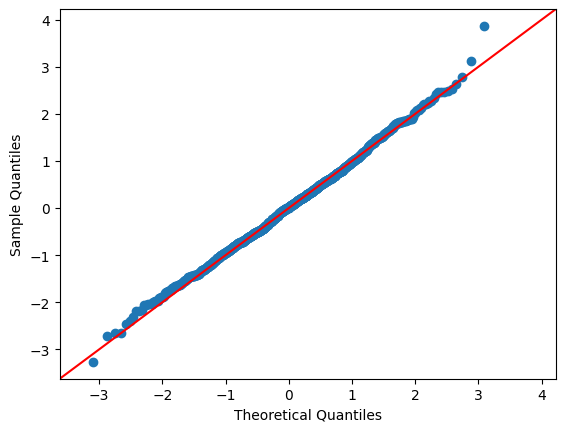

In [47]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

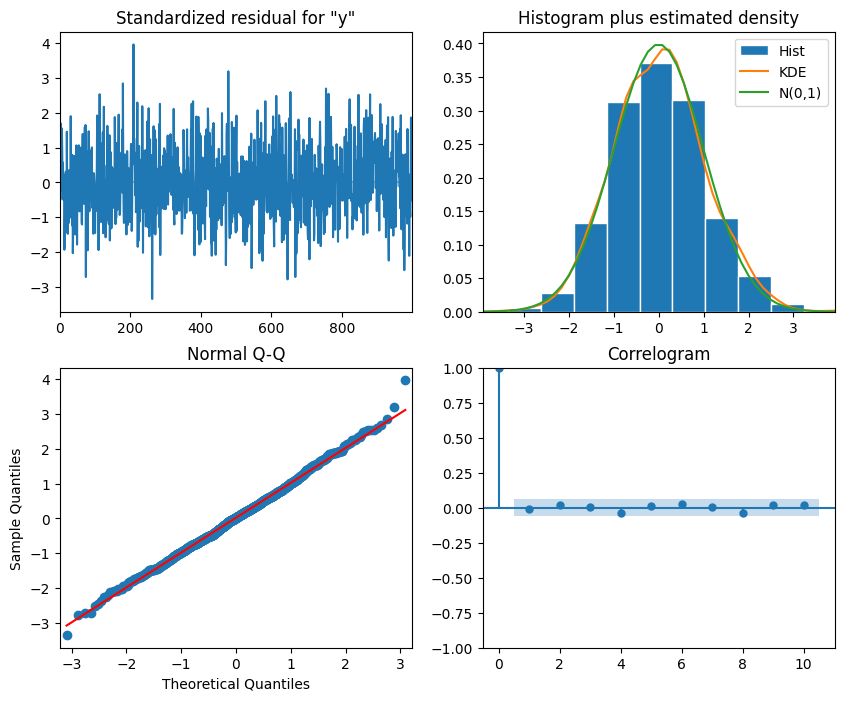

In [48]:
model_fit.plot_diagnostics(figsize=(10, 8));
plt.show()

We will use the `acorr_ljungbox` function from statsmodels to perform the Ljung-Box test on the
residuals. T

In [49]:
from statsmodels.stats.diagnostic import acorr_ljungbox

res = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(list(res["lb_pvalue"]))

[0.8608968443296098, 0.7679655744932814, 0.9098174548502981, 0.7210890121180753, 0.8103854568498216, 0.8217499592616883, 0.8940625434232103, 0.8175009257896444, 0.852419448194084, 0.8740931372416123]


The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the
null hypothesis cannot be rejected, **meaning that the residuals are independently distributed
and uncorrelated.**

## Applying the general modeling procedure

In [50]:
df = pd.read_csv('data/bandwidth.csv')

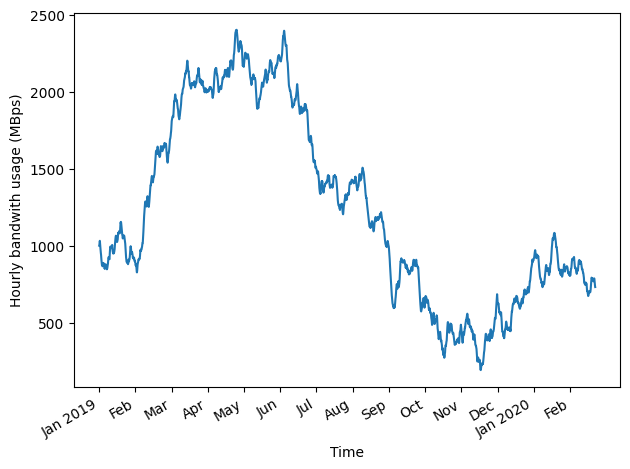

In [51]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [52]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452242
p-value: 0.7972240255014709


In [53]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

In [54]:
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789024
p-value: 0.0


In [55]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


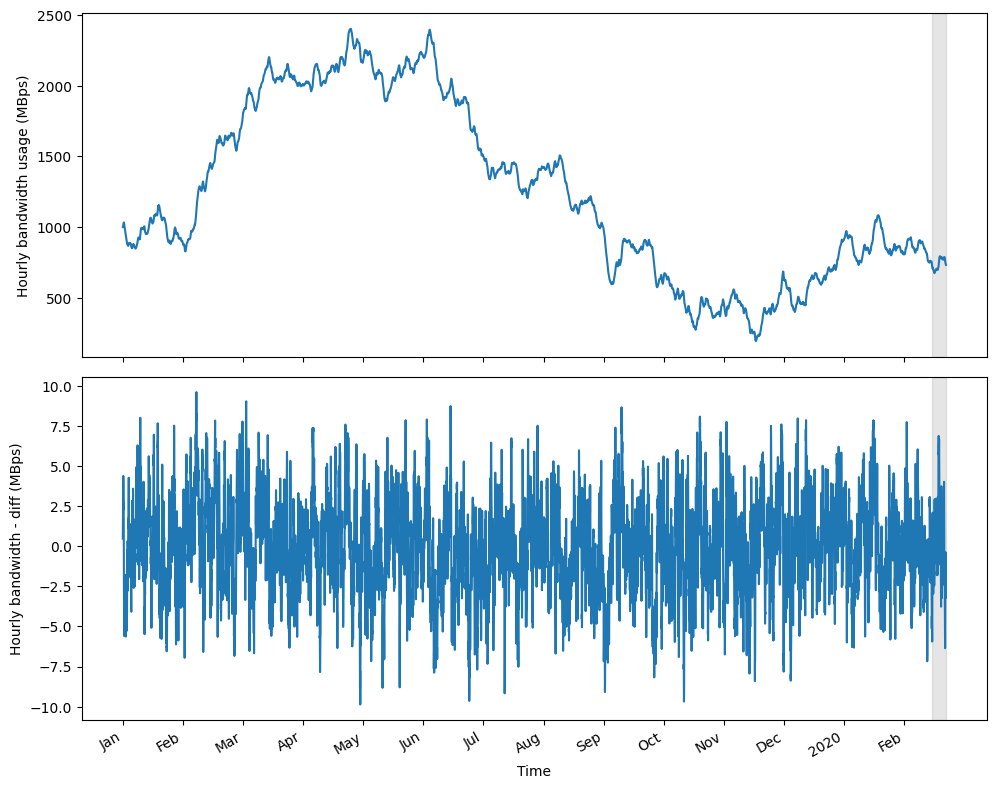

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [57]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [58]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [59]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


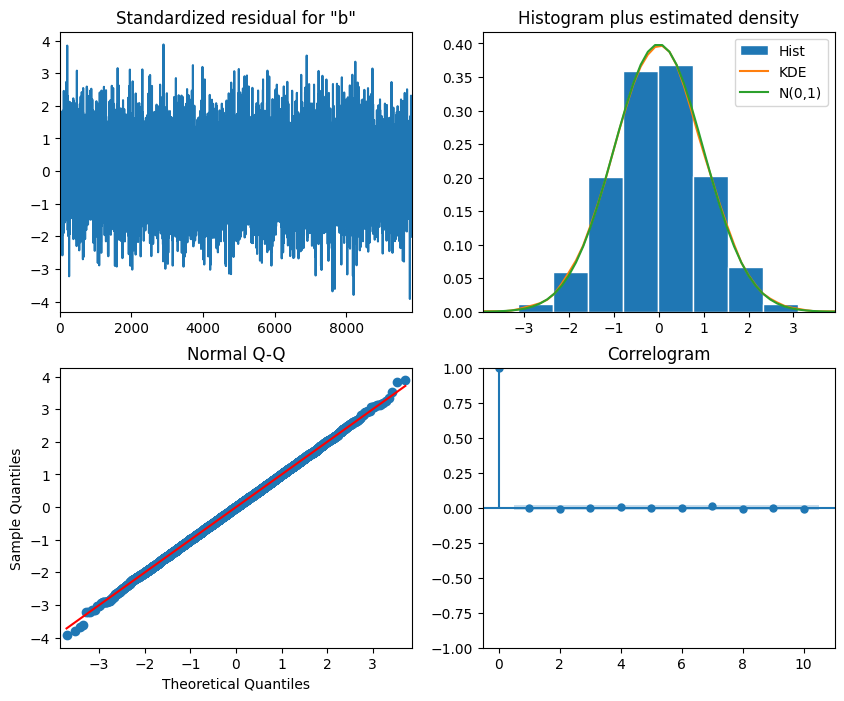

In [60]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [61]:
residuals = model_fit.resid
res = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(list(res["lb_pvalue"]))

[0.8372573230078721, 0.8112474290452685, 0.9144159686220706, 0.9315449031278678, 0.9736778759377183, 0.98101905583374, 0.9526071363416191, 0.9190666098195931, 0.9536150421094926, 0.9640151788749177]


## Forecasting bandwidth usage

ARMA (2, 2) -> MA(2) -> 2 predikciji v naprej

In [62]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [63]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

C:\Users\ygreg\AppData\Local\Temp\ipykernel_1032\2529208615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
C:\Users\ygreg\AppData\Local\Temp\ipykernel_1032\2529208615.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
C:\Users\ygreg\AppData\Local\Temp\ipykernel_1032\2529208615.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


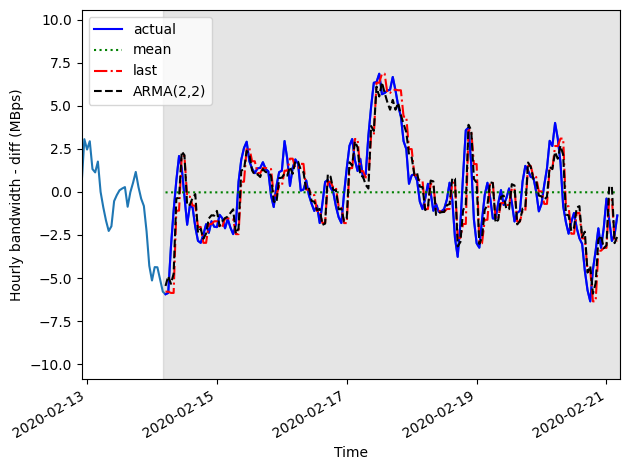

In [64]:
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [65]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462113569685


In [66]:
df['pred_bandwidth'] = pd.Series(dtype="float")
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

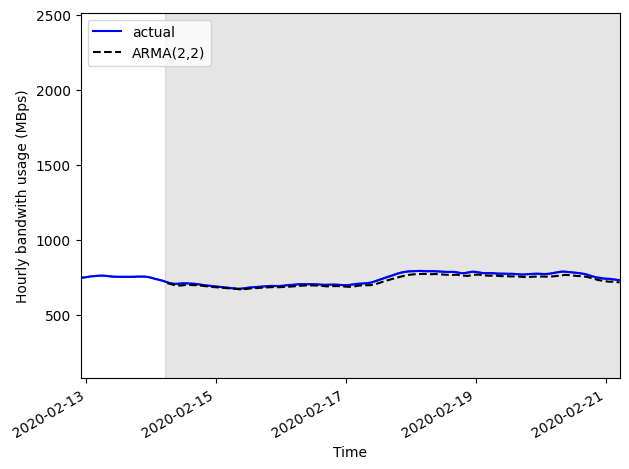

In [67]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [68]:
from sklearn.metrics import mean_absolute_error

mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362773493542


## Summary

- The autoregressive moving average model, denoted as `ARMA(p,q)`, is the combination of the autoregressive model `AR(p)` and the moving average model `MA(q)`.
- An ARMA(p,q) process **will display a decaying pattern or a sinusoidal pattern on both the ACF and PACF plots.** Therefore, they cannot be used to estimate the orders p and q.
- The general modeling procedure does not rely on the ACF and PACF plots. Instead, we fit many ARMA(p,q) models and perform **model selection and residual analysis.**
- Model selection is done with the Akaike information criterion (AIC). It quantifies the information loss of a model, and it is related to the number of parameters in a model and its goodness of fit. The lower the AIC, the better the model.
- The AIC is relative measure of quality. It returns the best model among other models. For an absolute measure of quality, we perform residual analysis.
- Residuals of a good model must approximate white noise, meaning that they must be uncorrelated, normally distributed, and independent.
- The Q-Q plot is a graphical tool for comparing two distributions. We use it to compare the distribution of the residuals against a theoretical normal distribution. If the plot shows a straight line that lies on y = x, then both distributions are similar. Otherwise, it means that the residuals are not normally distributed.
- The Ljung-Box test allows us to determine whether the residuals are correlated or not. The null hypothesis states that the data is independently distributed and uncorrelated. If the returned p-values are larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals are uncorrelated, just like white noise.